# Wasserstein variable projection: understanding classification models    


In [1]:
import numpy as np                     
import sklearn as sk                      
import matplotlib.pyplot as plt      
import pandas as pd                    
from tqdm import tqdm                  
from sklearn import preprocessing
from sklearn.model_selection import train_test_split


In [2]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.naive_bayes import GaussianNB as NB

## 1: Load and pre-process Adult Census data

Let's first give ourself a dataset which we will use on this tutorial, the preprocessing comes mainly from there :
https://github.com/XAI-ANITI/StoryOfBias/blob/master/StoryOfBias.ipynb

You can download the dataset itself here : https://www.kaggle.com/datasets/wenruliu/adult-income-datase

This dataset has personal information such as age, number of years spent studying, and martial status associated with the yearly income; more precisely, we will look at if those persons have a yearly income higher than $50,000.

### 1.1 Data loading

In [3]:
from LEFkit.data import LoadAndTreatAdultCensus

data_ohe = LoadAndTreatAdultCensus.get_treated_dataframe(verbose=False)

X_raw_col_names=data_ohe.columns

In [4]:
X = data_ohe.drop('Target', axis = 1)
Y = data_ohe['Target']

In [5]:
X_train, X_test , Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [ ]:
n=len(data_ohe)

In [ ]:
X_train.shape, n

((39073, 37), 48842)

In [ ]:
X_test.shape

(9769, 37)

In [ ]:
X_train.head()

,Age,Education-Num,OrigEthn,Gender,Capital Gain,Capital Loss,Hours per week,Child,Workclass_Federal-gov,Workclass_Local-gov,...,Occupation_Farming-fishing,Occupation_Handlers-cleaners,Occupation_Machine-op-inspct,Occupation_Other-service,Occupation_Priv-house-serv,Occupation_Prof-specialty,Occupation_Protective-serv,Occupation_Sales,Occupation_Tech-support,Occupation_Transport-moving
22729,20.0,10.0,0.0,0.0,0.0,0.0,40.0,1.0,0,0,...,0,0,0,0,0,0,0,0,0,0
8650,42.0,11.0,1.0,1.0,0.0,0.0,52.0,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0
26605,35.0,10.0,1.0,0.0,0.0,0.0,40.0,0.0,0,0,...,0,0,0,0,0,0,0,0,1,0
15864,39.0,9.0,1.0,0.0,0.0,0.0,16.0,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0
2516,24.0,13.0,1.0,1.0,0.0,0.0,40.0,0.0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [6]:
X_train_scaled = np.asarray(sk.preprocessing.StandardScaler().fit(X_train).transform(X_train))
X_test_scaled  = np.asarray(sk.preprocessing.StandardScaler().fit(X_test).transform(X_test))

## 2: Train different classifiers <a name="a-pred"></a>

The dataset Adult Income has many features in different scales, such as 'Age' and 'Capital Gain'. Some algorithms, such as Logistic Regression, are quite sensitive to different scales, since they are based in computations related to norms. In that cases, the classifier may be errouneously biased by some covariates with larger range. Because of that, it is desirable to standardize the features before training. One issue arises in this context: standardize after affine transformations makes no difference in our approach here. Specifically, the Wasserstein projection of a dataset is just a linear translation. If then it is standardized, the standardized version of the projected one is the same of the standardized version of the original dataset. It happens just because of the linearity of expectation. Then, if we standardize our data before training, our analysis would be lost. So we are going to examine only algorithms that are not sensitive to scaling.

### 2.1 Logistic regression <a name="a-logi"></a>

In [7]:
from sklearn.linear_model import LogisticRegression

clf_LR = LogisticRegression(solver='lbfgs',max_iter=500)
clf_LR.fit(X_train_scaled,Y_train)
pred_logi=1.*clf_LR.predict_proba(X_test_scaled)[:,1]

### no scaling:

In [8]:
clf_LR.fit(X_train,Y_train)
pred_logi_noscale=1.*clf_LR.predict_proba(X_test)[:,1]

c:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### 2.2 Decision Tree <a name="a-DT"></a>

In [9]:
from sklearn.tree import DecisionTreeClassifier

clf_DT=DecisionTreeClassifier(max_depth=5)
clf_DT.fit(X_train_scaled,Y_train)
pred_DT = clf_DT.predict_proba(X_test_scaled)[:,1]###returns predicted probs for each classes, im choosing the second one

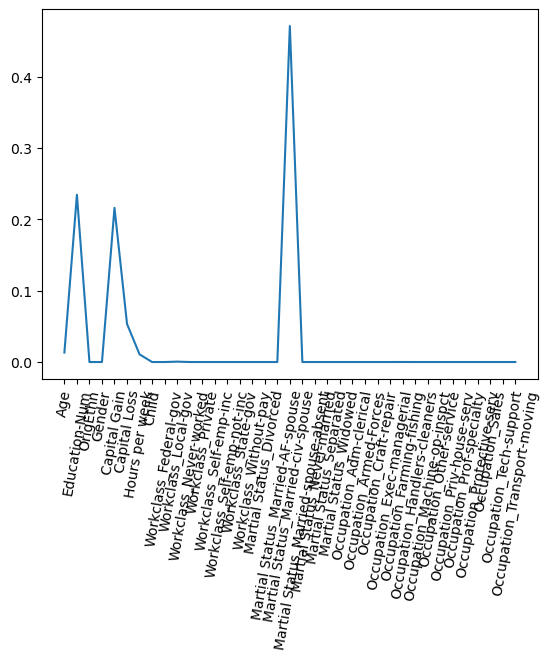

In [21]:
plt.plot(X_train.columns,clf_DT.feature_importances_)
plt.xticks(rotation=80)
plt.show()

### no scaling:

In [10]:
clf_DT.fit(X_train,Y_train)
pred_DT_noscale = clf_DT.predict_proba(X_test)[:,1]

### 2.3 Gradient boosting <a name="a-DT"></a>

In [11]:
from sklearn.ensemble import GradientBoostingClassifier

clf_GB=GradientBoostingClassifier()
clf_GB.fit(X_train_scaled,Y_train)
pred_GB = clf_GB.predict_proba(X_test_scaled)[:,1]



### no scaling:

In [12]:
clf_GB.fit(X_train,Y_train)
pred_GB_noscale = clf_GB.predict_proba(X_test)[:,1]

#### 2.4 LDA

In [13]:
sklearn_lda = LDA()
lda = sklearn_lda.fit(X_train, Y_train)
X_labels = lda.predict(X_train)
X_prob = lda.predict_proba(X_train)

X_test_labels_LDA = lda.predict(X_test) ###retorna a classe
X_test_prob_LDA = lda.predict_proba(X_test) ###retorna as probabilidades de estar em cada classe
 

### 2.5 QDA

In [14]:
sklearn_qda = QDA(store_covariance=True) # criando um objeto QDA
qda = sklearn_qda.fit(X_train, Y_train)
X_labels = qda.predict(X_train)
X_prob = qda.predict_proba(X_train)

X_test_labels_QDA=qda.predict(X_test)
X_test_prob_QDA = qda.predict_proba(X_test) 


c:\Users\user\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


### 2.6 Naive Bayes

In [15]:
NB_class = NB()
NB_class.fit(X_train, Y_train)
X_test_labels_NB=NB_class.predict(X_test)
X_test_prob_NB = NB_class.predict_proba(X_test) 

### 2.7 Prediction accuracy <a name="a-acc"></a>

In [16]:
Y_pred_logi=1*(pred_logi>0.5)
Y_pred_DT=1*(pred_DT>0.5)
Y_pred_GB=1*(pred_GB>0.5)

print('Accuracy WITH SCALING:')
print('Logistic regression accuracy is ', 1-np.mean(np.abs(Y_pred_logi-Y_test)))
print('Decision tree accuracy is ', 1-np.mean(np.abs(Y_pred_DT-Y_test)))
print('Gradient Boosting accuracy is ', 1-np.mean(np.abs(Y_pred_GB-Y_test)))

Accuracy WITH SCALING:
Logistic regression accuracy is  0.8498310983724024
Decision tree accuracy is  0.8437915856280069
Gradient Boosting accuracy is  0.8607841130105436


In [17]:
Y_pred_logi=1*(pred_logi_noscale>0.5)
Y_pred_DT=1*(pred_DT_noscale>0.5)
Y_pred_GB=1*(pred_GB_noscale>0.5)

print('Accuracy WITHOUT SCALING:')
print('Logistic regression accuracy is ', 1-np.mean(np.abs(Y_pred_logi-Y_test)))
print('Decision tree accuracy is ', 1-np.mean(np.abs(Y_pred_DT-Y_test)))
print('Gradient Boosting accuracy is ', 1-np.mean(np.abs(Y_pred_GB-Y_test)))

Accuracy WITHOUT SCALING:
Logistic regression accuracy is  0.8462483365748797
Decision tree accuracy is  0.8466577950660252
Gradient Boosting accuracy is  0.8672330842460846


In [18]:
print("Accuracy LDA is ", np.mean(Y_test==X_test_labels_LDA))
print("Accuracy QDA is ", np.mean(Y_test==X_test_labels_QDA))
print("Accuracy NB is ", np.mean(Y_test==X_test_labels_NB))



Accuracy LDA is  0.8370355205241069
Accuracy QDA is  0.5410993960487256
Accuracy NB is  0.8293581738151294


Since Logistic Regression is sensitive to scaling and the accuracy of QDA is very low, we will use only Decision Tree, Gradient Boosting, LDA and Naive Bayes algorithms. All of them are going to be trained with the NONSCALED dataset. Since the basic idea of tree classifiers and regressors is to find the best cut, tree-based algorithms are blind to feature scaling. The generative models for classification, Linear Discriminant Analysis, Quadratic Discriminant Analysis and Naive Bayes, are based in estimating the posterior probability of belonging to a class. This approach is also blind to feature scaling.

### 3. Study a classifier stressing feature mean

In [19]:
from classification_functions import *

### 3.1 Mean influence in portin of predicted 1's

##### 3.1.1 mean influence for all four models

In order to understand the influence of each covariate in the classification, we are going to follow three basic steps: train all four models in the same dataset X_train, determine the projections parametrized by $\tau$ of the test dataset X_test, and then compute the proportion of predicted 1's for these projected datasets.

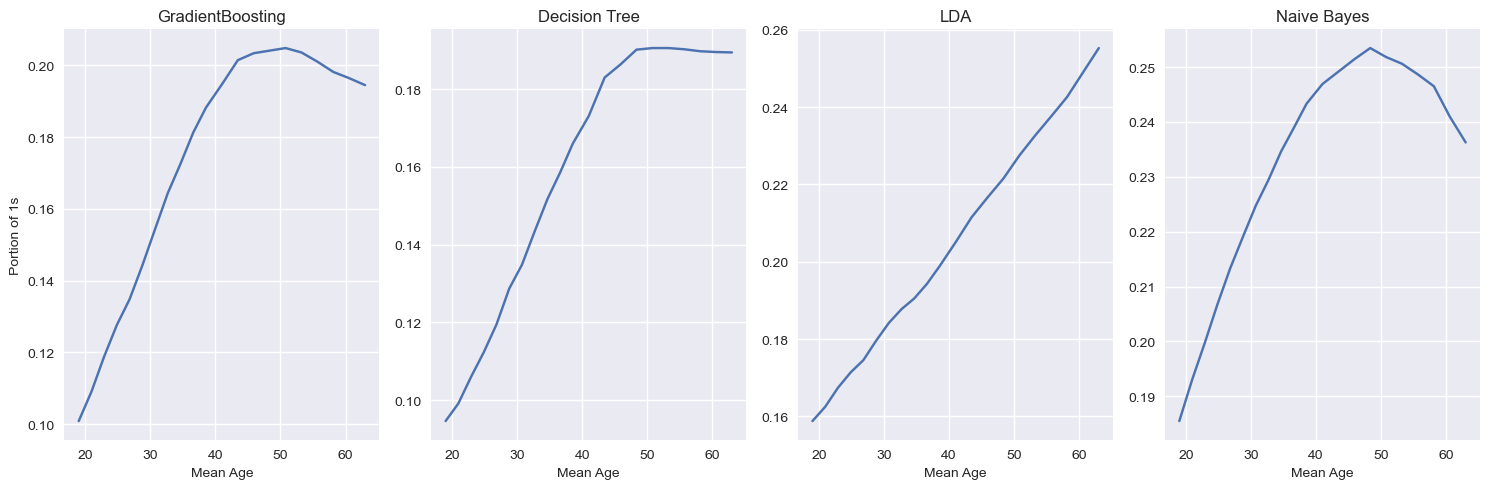

In [25]:
plot_mean_pp1(X_train, X_test, Y_train, 21, 0.05, 'Age')

As we can see by the figure, the feature 'Age' has a beneficial impact in positive classifications ($\geq$ 50k income) up to an age close to 50. On the other hand, the impact of 'Education-Num' is clear: as higher 'Education-Num' is, the chance of having an income greater than 50k is bigger.

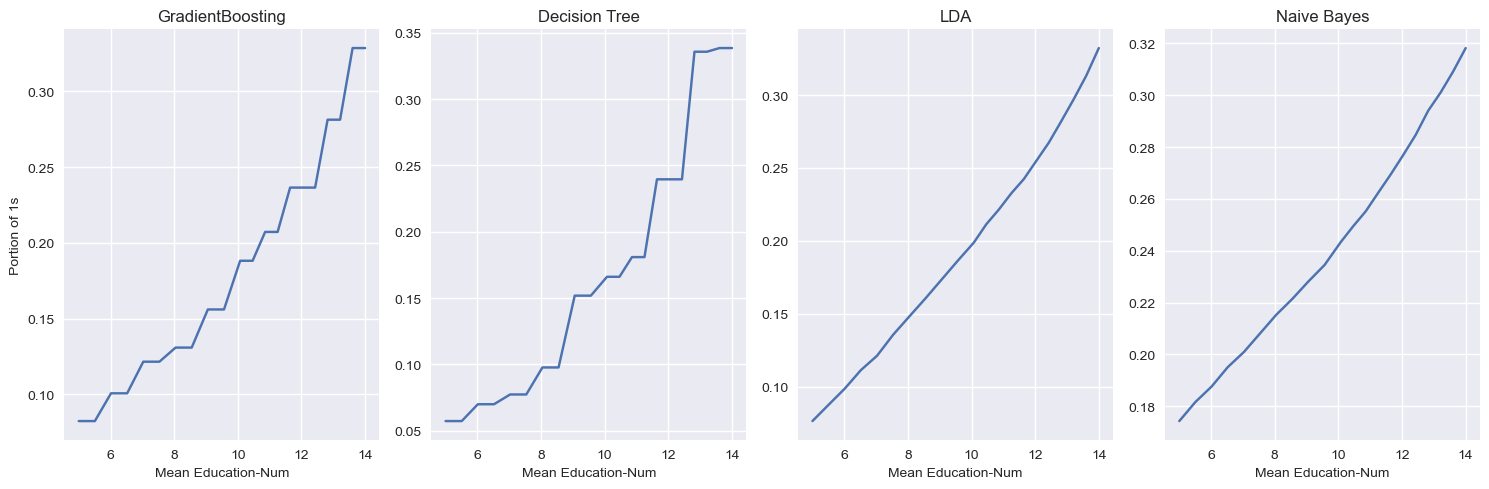

In [26]:
plot_mean_pp1(X_train, X_test, Y_train, 21, 0.05, 'Education-Num')

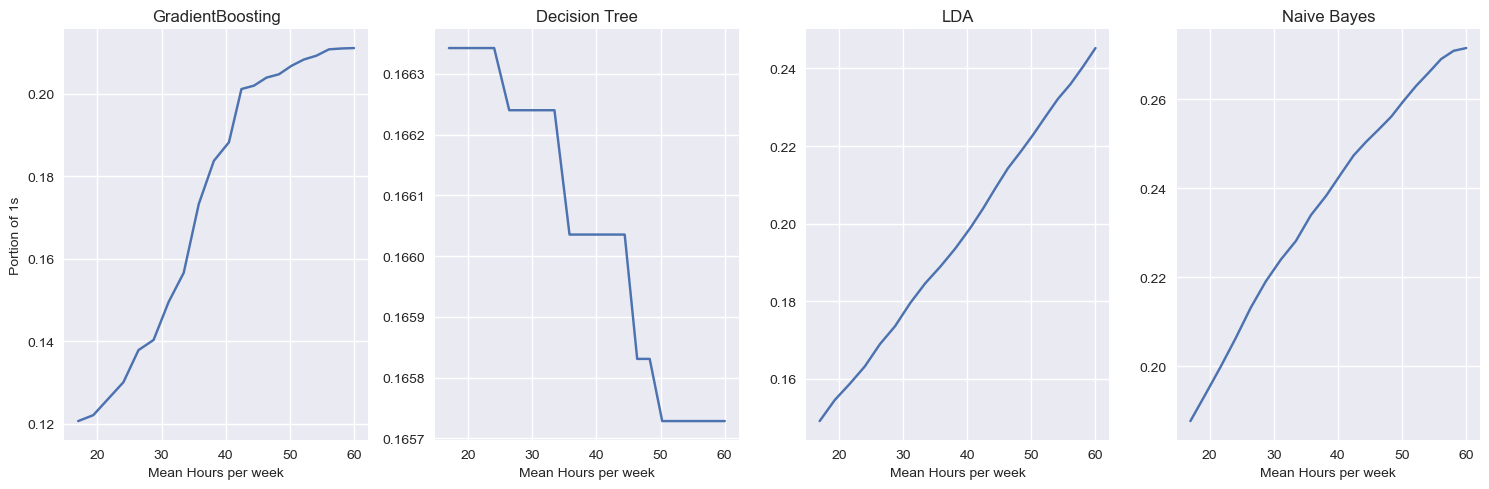

In [28]:
plot_mean_pp1(X_train, X_test, Y_train, 21, 0.05, 'Hours per week')

#### 3.1.2 Mean influence for one model

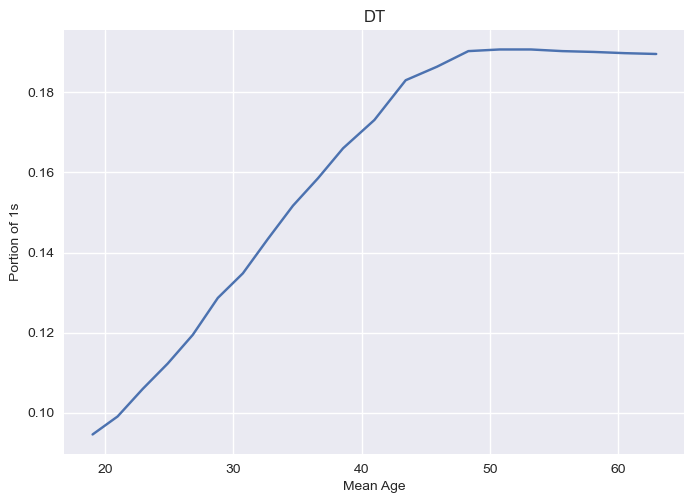

In [8]:
plot_mean_pp1_onemodel(X_train, X_test, Y_train, 21, 0.05, 'Age', 'DT')

### 3.2 Multiple mean stresses

In these 

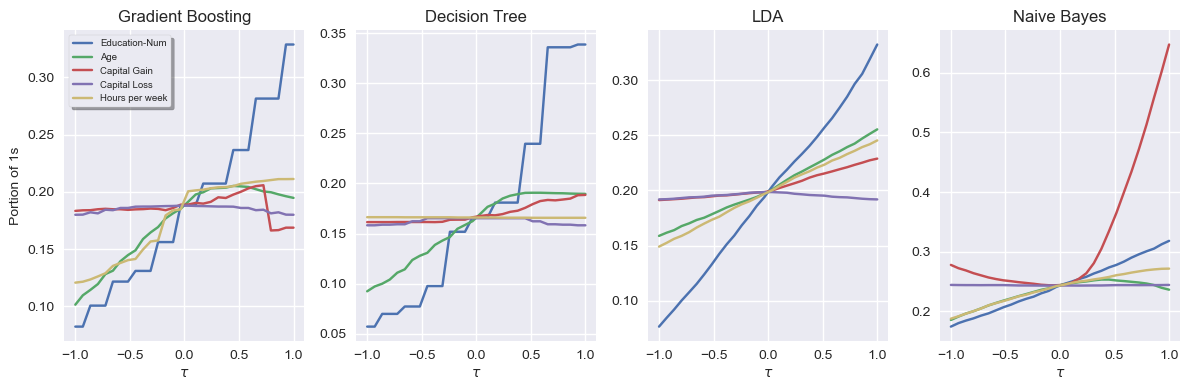

In [27]:
plot_multiplemean(X_train, X_test, Y_train, 30, 0.05)

### 3.3 Stressing two means simultaneously

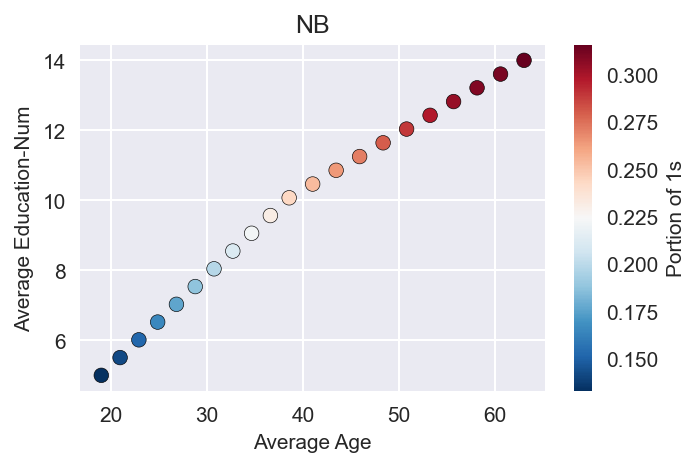

In [11]:
plot_twomeans(X_train, X_test, Y_train, 'Age', 'Education-Num', 21,  0.05, 'NB')

### 4. Disparate Impact

In [20]:
from LEFkit.bias_measure.bias_measure_fcts import *

In [21]:
X_col_names = list(X_train.columns)
X_col_names.index('Gender')

3

In [22]:
X_train['Child'].values

array([1., 0., 0., ..., 0., 0., 0.])

In [23]:
X=X_test.values
S = X[:,X_col_names.index('Gender')].ravel()

In [24]:
X.shape, S.shape, Y_pred_GB.shape

((9769, 37), (9769,), (9769,))

In [25]:
Cpt_DI(S,Y_pred_GB,w=1 ,alpha=0.05, boxplot=False, wedge=False)

(0.26496322792519156, [0.22864365865669714, 0.301282797193686])

In [30]:
#####generating new datasets and predictions for all models

In [230]:
X_train['Capital Loss'].value_counts()

0.0       37255
1902.0      253
1977.0      208
1887.0      181
2415.0       58
          ...  
2267.0        1
1539.0        1
2754.0        1
2465.0        1
155.0         1
Name: Capital Loss, Length: 97, dtype: int64

In [206]:
x_train = X_train
x_test = X_test
y_train = Y_train 
n_tau = 21
alpha = 0.05
col_name = 'Capital Loss'

In [239]:
###compute lambdas
list_lbd, list_t = comp_lambda(x_test, col_name, n_tau, alpha)
    
###compute new dataframes
dfs = []
for i in range(len(list_lbd)):
    data = new_dataset(x_test, col_name, list_lbd[i])
    dfs.append(data)

###instantiate the model
clf_DT=DecisionTreeClassifier(max_depth=5)
clf_DT.fit(x_train, y_train)

##compute portions of 1
dict_GB = {}
for i in range(len(dfs)):
    pred_GB = clf_DT.predict_proba(dfs[i])[:,1]
    Y_pred_GB=1*(pred_GB>0.5)
    dict_GB[list_t[i]] = Y_pred_GB
    print(len(dict_GB.keys()))

1
2
3
4
5
6
7
8
9
10
11
11
12
13
14
14
15
16
16
17
17


In [222]:
list1 = [11, 15, 18, 20]
for i in list1:
    pred_GB = clf_GB.predict_proba(dfs[i])[:,1]
    Y_pred_GB=1*(pred_GB>0.5)
    dict_GB[list_t[i]] = Y_pred_GB

In [229]:
len(dict_GB.keys())

17

In [233]:
dfs2 = [dfs[11], dfs[15], dfs[18], dfs[20]]
dict_GB = {}
for i in range(len(dfs2)):
    pred_GB = clf_DT.predict_proba(dfs2[i])[:,1]
    Y_pred_GB=1*(pred_GB>0.5)
    dict_GB[list_t[i]] = Y_pred_GB
    #print(dict_GB.keys())

In [241]:
list_t

[0.0,
 8.869495342409664,
 17.738990684819328,
 26.608486027229,
 35.477981369638655,
 44.34747671204832,
 53.21697205445799,
 62.086467396867654,
 70.95596273927731,
 79.82545808168697,
 88.69495342409664,
 79.82545808168697,
 70.9559627392773,
 62.08646739686765,
 53.21697205445797,
 44.34747671204832,
 35.47798136963865,
 26.608486027228977,
 17.738990684819328,
 8.86949534240965,
 0.0]

In [234]:
len(dict_GB.keys())

4

In [150]:
len(dict_GB.keys())

21

In [209]:
dis = []
yerr = []
sizes = []
for key in dict_GB.keys():
    y = dict_GB[key]
    di = Cpt_DI(S, y,w=1 ,alpha=0.05, boxplot=False, wedge=False)[0]
    errs =  Cpt_DI(S, y,w=1 ,alpha=0.05, boxplot=False, wedge=False)[1]
    dis.append(di)
    yerr.append(errs)

In [236]:
len(list_t), len(dis), len(dict_GB), len(dfs)

(21, 17, 17, 21)

In [191]:
list_t[10]

38.529941652165014

In [192]:
np.mean(x_test['Age'])

38.529941652165014

In [ ]:
plt.style.use('default')

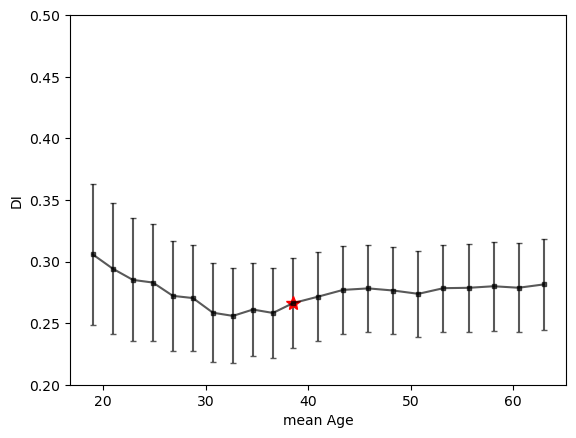

In [201]:
plt.errorbar(list_t, dis, yerr = sizes, color = 'k', capsize=2, marker="s", markersize=3.5, mfc="k", mec="k", alpha = 0.65)
plt.plot(list_t[10], dis[10], marker = '*',markersize=10, color = 'r')
plt.xlabel(f'mean {col_name}')
plt.ylabel("DI")
plt.ylim(0.2,0.5)
plt.show()

In [256]:
a = np.arange(3)
b = np.arange(3)-1
c = zip(a,b)
print(c)

In [270]:
def plot_di4(x_train, x_test, y_train, n_tau, alpha):
    cols = ['Age', 'Education-Num', 'Capital Gain', 'Hours per week']
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12, 4))
    axs = [ax1, ax2, ax3, ax4]
    for col_name, ax in zip(cols, axs):
        list_t, dis, sizes = plot_di_one(x_train, x_test, y_train, n_tau, alpha, col_name)
        ax.errorbar(list_t, dis, yerr = sizes, color = 'k', capsize=2, marker="s", markersize=3.5, mfc="k", mec="k", alpha = 0.65)
        ax.plot(list_t[10], dis[10], marker = '*',markersize=10, color = 'r')
        ax.set_xlabel(f'Average {col_name}')
        ax.set_ylim(0.2,0.5)
    ax1.set_ylabel("DI")
    fig.tight_layout()
    plt.show()


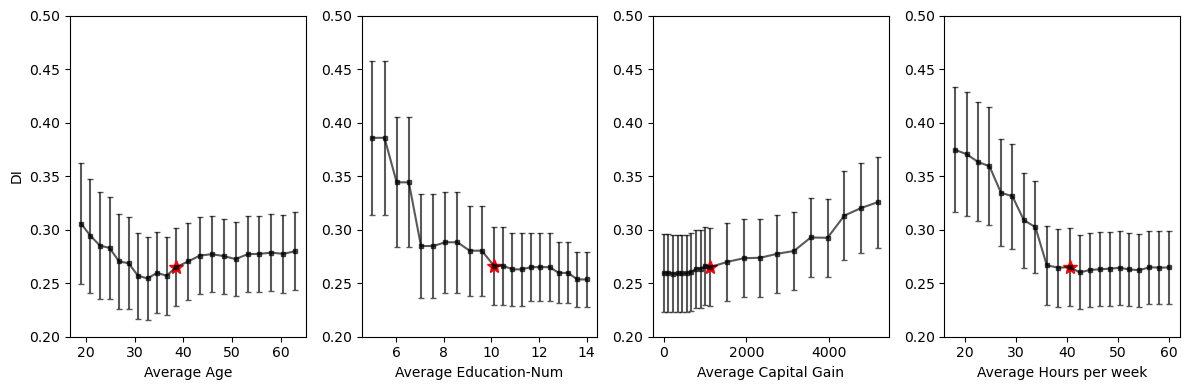

In [271]:
plot_di4(x_train, x_test, y_train, n_tau, alpha)

In [254]:
def plot_di_one(x_train, x_test, y_train, n_tau, alpha, col_name):
    ###compute lambdas
    list_lbd, list_t = comp_lambda(x_test, col_name, n_tau, alpha)
    
    ###compute new dataframes
    dfs = []
    for i in range(len(list_lbd)):
        data = new_dataset(x_test, col_name, list_lbd[i])
        dfs.append(data)

    ###instantiate the model
    clf_GB = GradientBoostingClassifier()
    clf_GB.fit(x_train, y_train)

    ##compute portions of 1
    dict_GB = {}
    for i in range(len(dfs)):
        pred_GB = clf_GB.predict_proba(dfs[i])[:,1]
        Y_pred_GB=1*(pred_GB>0.5)
        dict_GB[list_t[i]] = Y_pred_GB
    
    dis = []
    yerr = []
    for key in dict_GB.keys():
        y = dict_GB[key]
        di = Cpt_DI(S, y,w=1 ,alpha=0.05, boxplot=False, wedge=False)[0]
        errs =  Cpt_DI(S, y,w=1 ,alpha=0.05, boxplot=False, wedge=False)[1]
        dis.append(di)
        yerr.append(errs)
    
    sizes = []
    for i in range(len(yerr)):
        err = yerr[i][1] - dis[i]
        sizes.append(err)

    return list_t, dis, sizes

In [251]:
def plot_di(x_train, x_test, y_train, n_tau, alpha, col_name):
    plt.style.use("default")
    ###compute lambdas
    list_lbd, list_t = comp_lambda(x_test, col_name, n_tau, alpha)
    
    ###compute new dataframes
    dfs = []
    for i in range(len(list_lbd)):
        data = new_dataset(x_test, col_name, list_lbd[i])
        dfs.append(data)

    ###instantiate the model
    clf_GB = GradientBoostingClassifier()
    clf_GB.fit(x_train, y_train)

    ##compute portions of 1
    dict_GB = {}
    for i in range(len(dfs)):
        pred_GB = clf_GB.predict_proba(dfs[i])[:,1]
        Y_pred_GB=1*(pred_GB>0.5)
        dict_GB[list_t[i]] = Y_pred_GB
    
    dis = []
    yerr = []
    for key in dict_GB.keys():
        y = dict_GB[key]
        di = Cpt_DI(S, y,w=1 ,alpha=0.05, boxplot=False, wedge=False)[0]
        errs =  Cpt_DI(S, y,w=1 ,alpha=0.05, boxplot=False, wedge=False)[1]
        dis.append(di)
        yerr.append(errs)
    
    sizes = []
    for i in range(len(yerr)):
        err = yerr[i][1] - dis[i]
        sizes.append(err)

    plt.errorbar(list_t, dis, yerr = sizes, color = 'k', capsize=2, marker="s", markersize=3.5, mfc="k", mec="k", alpha = 0.65)
    plt.plot(list_t[10], dis[10], marker = '*',markersize=10, color = 'r')
    plt.xlabel(f'mean {col_name}')
    plt.ylabel("DI")
    #plt.ylim(0.2,0.5)
    plt.show()
 

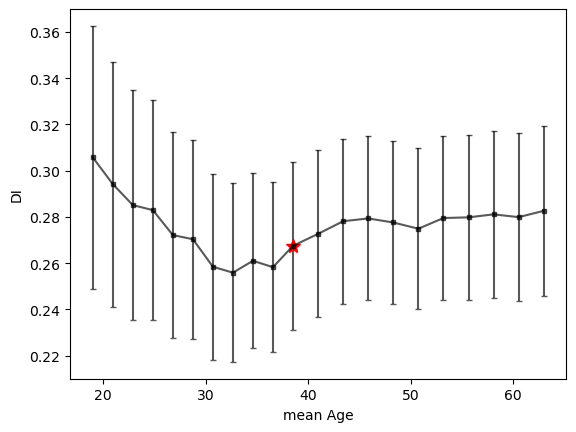

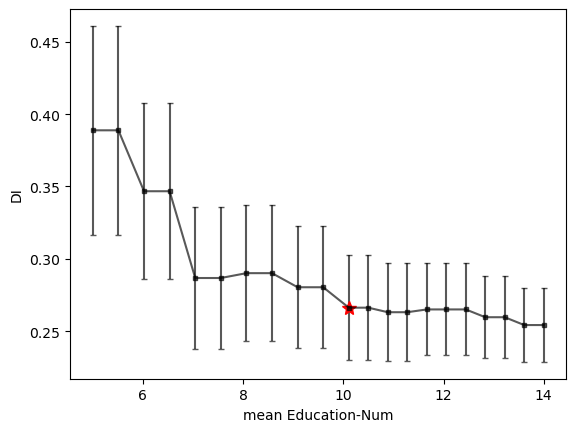

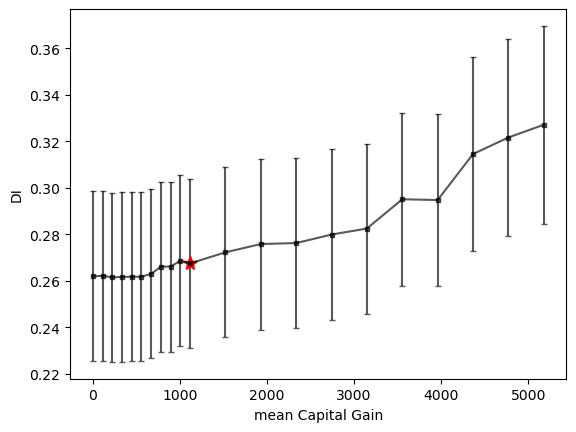

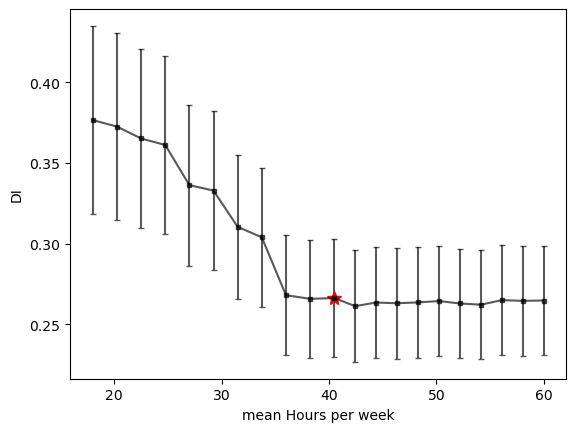

In [253]:
cols = ['Age', 'Education-Num', 'Capital Gain', 'Hours per week']
for colname in cols:
    plot_di(x_train, x_test, y_train, n_tau, alpha, colname)

In [ ]:
def plot_di_mean(x_train, x_test, y_train, n_tau, alpha, col_name, model):
    plt.style.use("seaborn")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    for col_name in 
    ###compute lambdas
    list_lbd, list_t = comp_lambda(x_test, col_name, n_tau, alpha)

    ###compute new dataframes
    dfs = []
    for i in range(len(list_lbd)):
        data = new_dataset(x_test, col_name, list_lbd[i])
        dfs.append(data)

    ###instantiate the model
    clf_GB = GradientBoostingClassifier()
    clf_GB.fit(x_train, y_train)

    ##compute portions of 1
    dict_GB = {}
    for i in range(len(dfs)):
        pred_GB = clf_GB.predict_proba(dfs[i])[:,1]
        Y_pred_GB=1*(pred_GB>0.5)
        dict_GB[list_t[i]] = Y_pred_GB


In [ ]:

    #n = Y_pred_GB.shape[0]
    #portion = np.sum(Y_pred_GB)/n
    #portions_GB.append(portion) 
    
##instantiate the model
clf_DT=DecisionTreeClassifier(max_depth=5)
clf_DT.fit(x_train, y_train)

##compute portions of 1
portions_DT = []
for i in range(len(dfs)):
    pred_DT = clf_DT.predict_proba(dfs[i])[:,1]
    Y_pred_DT=1*(pred_DT>0.5)
    n = Y_pred_DT.shape[0]
    portion = np.sum(Y_pred_DT)/n
    portions_DT.append(portion)
   
##instantiate the model
sklearn_lda = LDA()
lda = sklearn_lda.fit(x_train, y_train)
        
##compute portions of 1
portions_LDA = []
for i in range(len(dfs)):
    pred_lda = lda.predict_proba(dfs[i])[:,1]
    Y_pred_lda=1*(pred_lda>0.5)
    n = Y_pred_lda.shape[0]
    portion = np.sum(Y_pred_lda)/n
    portions_LDA.append(portion)


##instantiate the model
clf_NB = NB()
clf_NB.fit(x_train, y_train)
        
##compute portions of 1
portions_NB = []
for i in range(len(dfs)):
    X_test_prob_NB = clf_NB.predict_proba(dfs[i])[:,1]
    Y_pred_NB=1*(X_test_prob_NB>0.5)
    n = Y_pred_NB.shape[0]
    portion = np.sum(Y_pred_NB)/n
    portions_NB.append(portion)